In [34]:
# Adjust the import according to what you installed
import gymnasium as gym

# Attempt to create and reset an environment
env = gym.make('CartPole-v1')  # Ensure 'CartPole-v1' is available in the installed package
env.reset()
print("Environment is ready.")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecMonitor

import sys
sys.path.append("../")

import os 
import optuna

from mbt_gym.agents.SbAgent import SbAgent

from mbt_gym.agents.BaselineAgents import CarteaJaimungalMmAgent
from mbt_gym.agents.BaselineAgents import AvellanedaStoikovAgent
from mbt_gym.gym.helpers.generate_trajectory import generate_trajectory
from mbt_gym.gym.StableBaselinesTradingEnvironment import StableBaselinesTradingEnvironment
from mbt_gym.gym.TradingEnvironment import TradingEnvironment
from mbt_gym.gym.wrappers import *
from mbt_gym.rewards.RewardFunctions import PnL, CjMmCriterion, RunningInventoryPenalty
from mbt_gym.stochastic_processes.midprice_models import BrownianMotionMidpriceModel, BrownianMotionJumpMidpriceModel, GeometricBrownianMotionMidpriceModel, BrownianMotionJumpMidpriceModelTesting, GeometricBrownianMotionMidpriceModelTesting
from mbt_gym.stochastic_processes.arrival_models import PoissonArrivalModel, HawkesArrivalModel, HawkesArrivalModelTesting
from mbt_gym.stochastic_processes.fill_probability_models import ExponentialFillFunction
from mbt_gym.gym.ModelDynamics import LimitOrderModelDynamics, LimitOrderModelDynamicsTesting
from mbt_gym.gym.backtesting import get_sharpe_ratio
from mbt_gym.gym.helpers.plotting import *
from mbt_gym.gym.helpers.helper2 import *


import importlib

Environment is ready.


In [35]:
terminal_time = 1.0
arrival_rate = 10.0
n_steps = int(100 * terminal_time * arrival_rate)
phi = 0.5
alpha = 0.001

In [36]:
def get_Hk_OF(num_trajectories:int = 1):
    fill_exponent = 1
    sigma = 1
    initial_inventory = (0,1) # 0$ in cash and 1 stock
    initial_price = 100
    step_size = 1/n_steps
    timestamps = np.linspace(0, terminal_time, n_steps + 1)
    midprice_model = BrownianMotionMidpriceModel(volatility=sigma, step_size=1/n_steps,
                                                 num_trajectories=num_trajectories)
    
    # I should maybe specify the baseline rate
    arrival_model = HawkesArrivalModel(step_size=1/n_steps, 
                                        num_trajectories=num_trajectories)
    fill_probability_model = ExponentialFillFunction(fill_exponent=fill_exponent, 
                                                     step_size=1/n_steps,
                                                     num_trajectories=num_trajectories)
    LOtrader = LimitOrderModelDynamics(midprice_model = midprice_model, arrival_model = arrival_model, 
                                fill_probability_model = fill_probability_model,
                                num_trajectories = num_trajectories)
    reward_function = RunningInventoryPenalty(per_step_inventory_aversion = phi, terminal_inventory_aversion = alpha)

    env_params = dict(terminal_time=terminal_time, 
                      n_steps=n_steps,
                      initial_inventory = initial_inventory,
                      model_dynamics = LOtrader,
                      max_inventory=n_steps,
                      normalise_action_space = False,
                      normalise_observation_space = False,
                      reward_function = reward_function,
                      num_trajectories=num_trajectories)
    return TradingEnvironment(**env_params)

In [37]:
num_trajectories = 1000
env = (get_Hk_OF(num_trajectories))
sb_env = StableBaselinesTradingEnvironment(trading_env=env)

# Vectorize the environment so it can train the n environment at each step
sb_env = VecMonitor(sb_env)

# Add directory for tensorboard logging and best model
base_tensorboard_logdir = "./Clean_version1/"

#BM, sigma = 1, total_timesteps = 20_000_000, epoch = 5
agent_name = "X"
tensorboard_logdir = os.path.join(base_tensorboard_logdir, agent_name)

# Architecture of the policy network

policy_kwargs = dict(net_arch=[dict(pi=[256, 256], vf=[256, 256])]) # two hidden layers containing 256 units each for policy network and value function

PPO_params = {"policy":'MlpPolicy', # Multi-layer perceptron policy
              "env": sb_env,
              #"learning_rate": 0.005,
              "verbose":1, # Print out training information
              "policy_kwargs":policy_kwargs, 
              "tensorboard_log":tensorboard_logdir,
              "n_epochs":5, # Number of epochs
              "batch_size": int(n_steps * num_trajectories / 10), # Number of batch
              "n_steps": int(n_steps)} # Number of steps to run for each environment per update

callback_params = dict(eval_env=sb_env, n_eval_episodes = 2048, #200 before  (n_eval_episodes)
                       deterministic=True)

callback = EvalCallback(**callback_params)
model = PPO(**PPO_params, device="cpu")



Using cpu device


c:\Users\jean-\OneDrive\Bureau\MA2\Reinforcement Learning\Reinforcement-Learning\.venv3108\lib\site-packages\stable_baselines3\common\vec_env\base_vec_env.py:77: UserWarning: The `render_mode` attribute is not defined in your environment. It will be set to None.
  warnings.warn("The `render_mode` attribute is not defined in your environment. It will be set to None.")
c:\Users\jean-\OneDrive\Bureau\MA2\Reinforcement Learning\Reinforcement-Learning\.venv3108\lib\site-packages\stable_baselines3\common\policies.py:484: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(


In [38]:
model.learn(total_timesteps = 10_000_000)  # Increase number of training timesteps according to computing resources

Logging to ./Clean_version1/X\PPO_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -56.5    |
| time/              |          |
|    fps             | 289236   |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 1000000  |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | -52.3        |
| time/                   |              |
|    fps                  | 56468        |
|    iterations           | 2            |
|    time_elapsed         | 35           |
|    total_timesteps      | 2000000      |
| train/                  |              |
|    approx_kl            | 0.0022871234 |
|    clip_fraction        | 0.00522      |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.84        |
|    explained_varianc

In [51]:
ppo_agent = SbAgent(model)

observations, actions, rewards = generate_trajectory(sb_env, ppo_agent)

# Squeeze for the dimenson
rewards = np.squeeze(rewards, axis=1)

# Disregard the end value of observation (starting env)
observations = observations[:,:,:-1]

In [49]:
def plot_agent(observations,actions,rewards, bool):
    " Will generate the plot for the agent at a random trajectory if bool is True. If its false it will plot the worst one"

    if bool:
        j = np.random.randint(0, observations.shape[0])
    else:
        j = np.argmin(rewards[:, -1])  

    # Set Seaborn style to dark
    sns.set(style="darkgrid")

    # Create a 2x2 subplot
    fig, axs = plt.subplots(2, 3, figsize=(14, 10))


    # Plot 3: Cash and inventory for a single trajectory
    axs[0, 0].plot(observations[j, 1, :], label='Inventory')
    axs[0, 0].set_title(f'Inventory process for trajectory {j}')
    axs[0, 0].set_xlabel("Step")
    axs[0, 0].set_ylabel("Quantity assets held")

    # Plot 2: Cash and inventory for a single trajectory
    axs[0, 1].plot(observations[j, 0, :], label='Cash')
    axs[0, 1].set_title(f'Cash process for trajectory {j}')
    axs[0, 1].set_xlabel("Step")
    axs[0, 1].set_ylabel("Money")


    # Plot 3: Cumulative reward at each step
    axs[1, 0].plot(np.cumsum(rewards, axis=-1)[j])
    axs[1, 0].set_title(f"Cumulative reward of the agent for trajectory {j}")
    axs[1, 0].set_xlabel("Step")
    axs[1, 0].set_ylabel("Cumulative reward")


    # Plot 1: Actions for a single trajectory
    axs[1, 1].plot(observations[j, 3, :], label='$s_t$')
    axs[1, 1].plot(-actions[j,1,:] + observations[j, 3, :], alpha = 0.6, label="$p_{t}^{bid}$")
    axs[1, 1].plot(actions[j,0,:] + observations[j, 3, :] , alpha = 0.6, label="$p_{t}^{ask}$")
    axs[1, 1].set_title(f"Potential actions of the agent for trajectory {j}")
    axs[1, 1].set_xlabel("Step")
    axs[1, 1].set_ylabel("Price")
    axs[1, 1].legend()


    axs[0, 2].plot(observations[j, 4, :], label='Arrival Model State', color='b')
    axs[0, 2].set_ylabel("Number of times the midprice changes")
    axs[0, 2].set_xlabel("Step")
    axs[0, 2].set_title('Arrival stochastic process')

    axs[1, 2].plot(observations[j, 5, :])
    axs[1, 2].set_title('Price impact')
    axs[1,2].set_xlabel("Step")

    # Save the plot to a file
    plt.savefig('agent_plot.png', dpi=300, bbox_inches='tight', format='pdf')  # Save as PNG file with 300 dpi resolution

    # Adjust layout
    plt.tight_layout()
    plt.show()


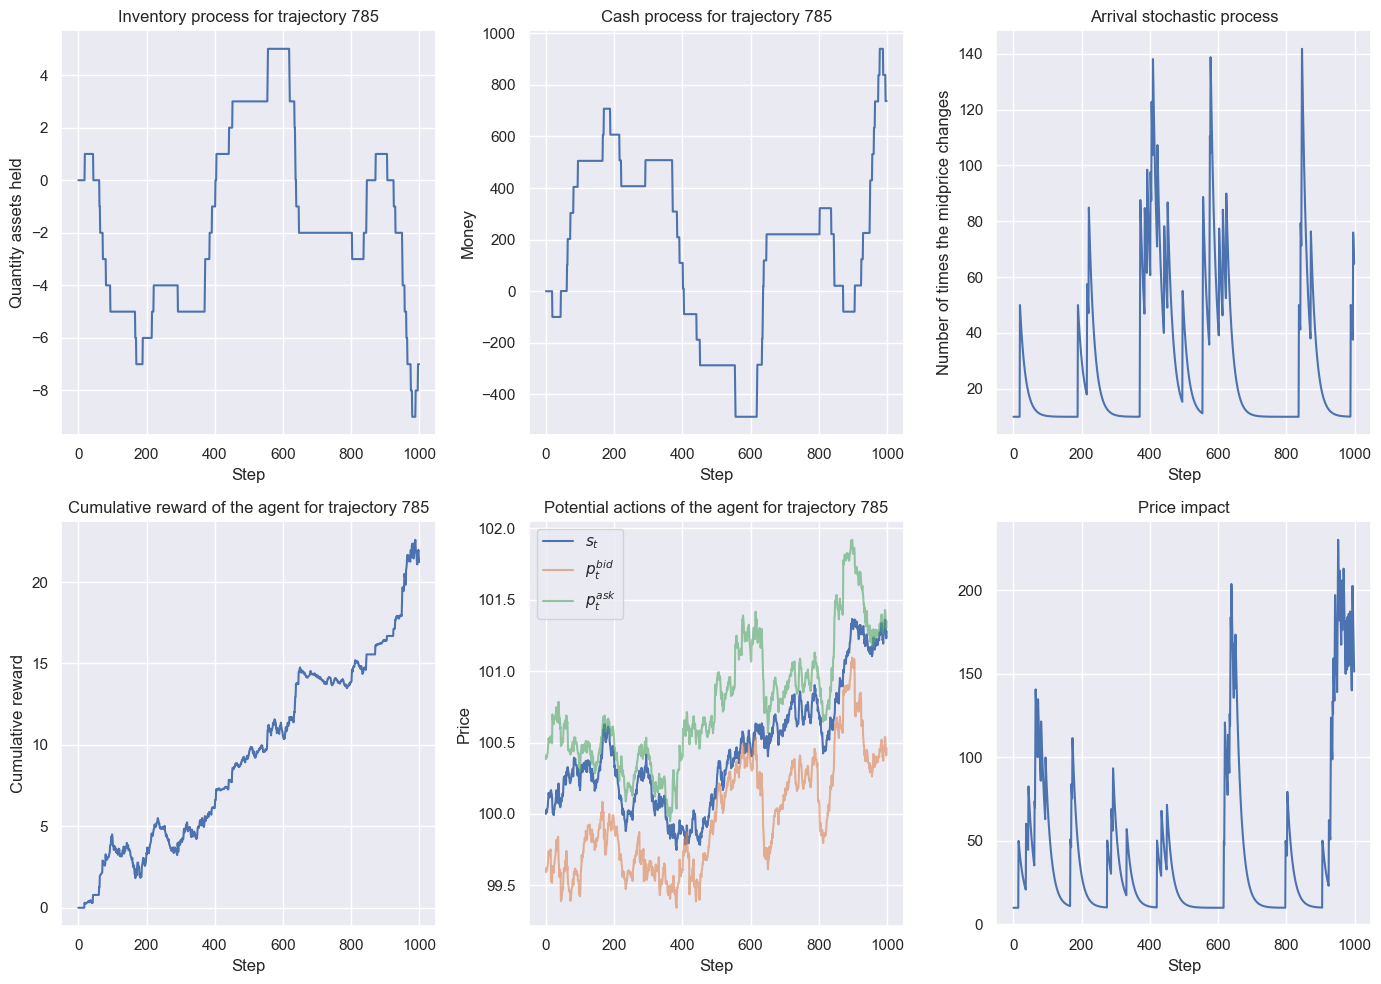

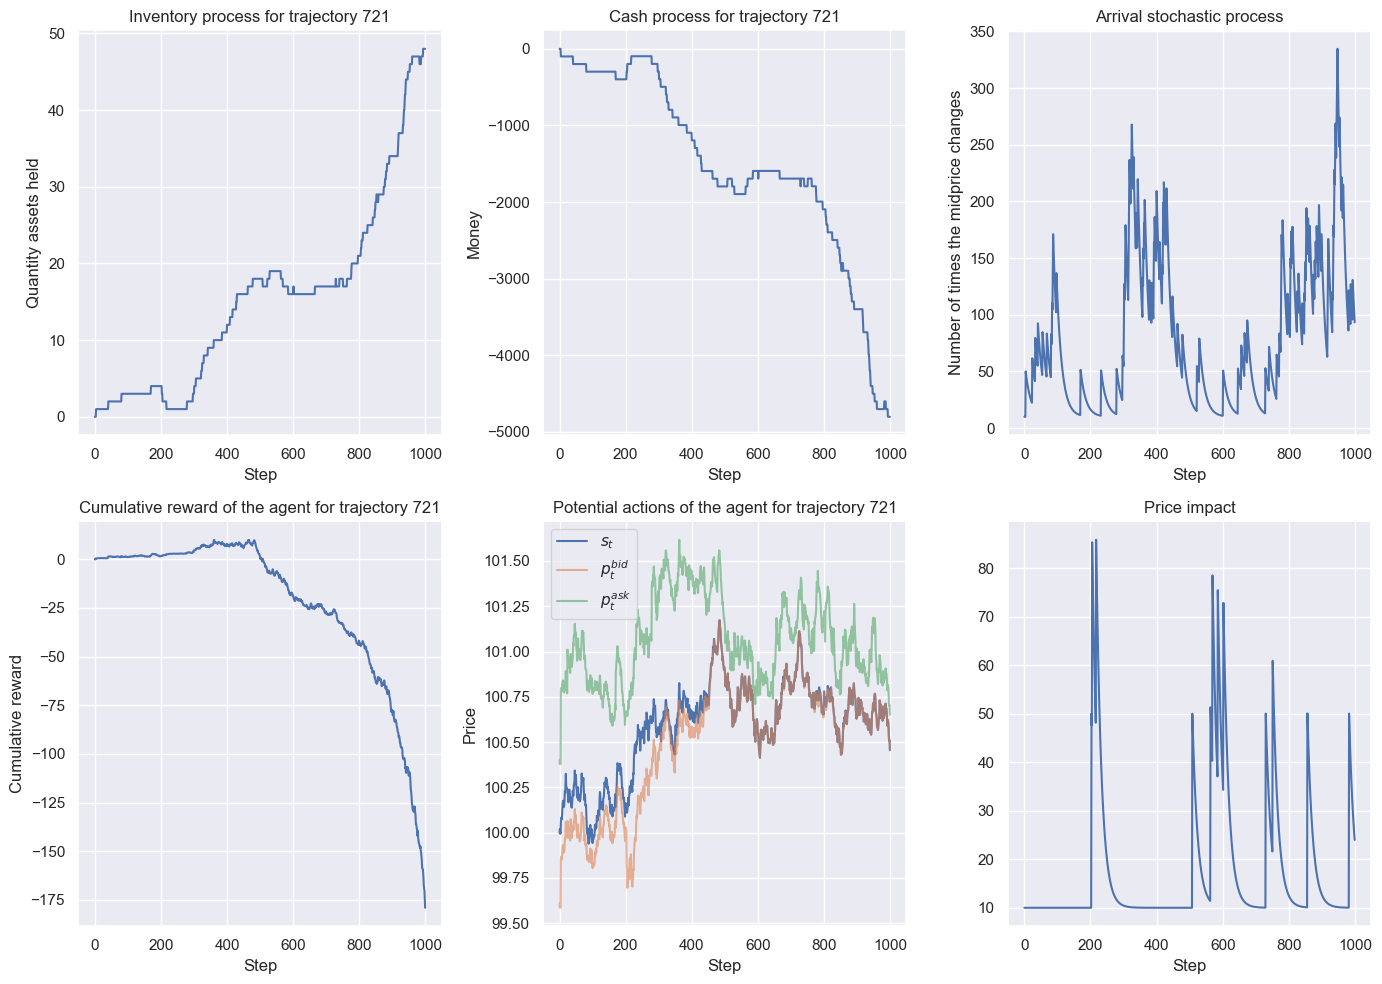

In [54]:
plot_agent(observations,actions,rewards, True)

plot_agent(observations,actions,rewards, False)

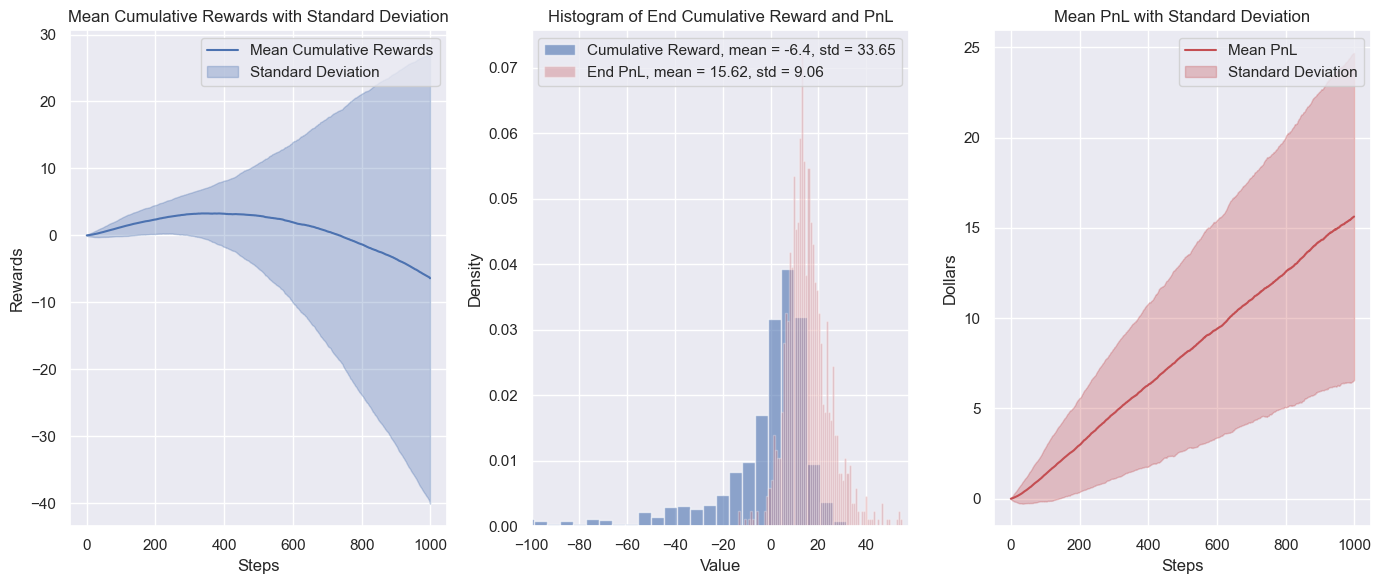

In [41]:
plot_meanAgent(observations,actions,rewards)

In [42]:
def trading_test(df: pd.DataFrame, num_trajectories:int = 1):
    fill_exponent = 2
    sigma = 0.0001
    initial_inventory = (0, 1) # 0$ in cash and 1$ dollars in stock
    initial_price = df.iloc[0, 1] # Midprice at first time step
    step_size = df.iloc[1, 0] # 0.25
    n_steps = df.shape[0] # Number of rows
    terminal_time = df.iloc[-1, 0] # In seconds
    timestamps = np.linspace(0, terminal_time, n_steps)
    
    midprice_model = BrownianMotionJumpMidpriceModelTesting(
        volatility=sigma, 
        step_size=step_size, 
        jump_size=0,
        num_trajectories=num_trajectories,
        initial_price=initial_price,
        data=df['midprice']
    )
    
    arrival_model = HawkesArrivalModelTesting(
        baseline_arrival_rate=np.array([[1.0, 1.0]]),
        step_size=step_size,
        num_trajectories=num_trajectories,
        data=df['arrivals']
    )
    
    fill_probability_model = ExponentialFillFunction(
        fill_exponent=fill_exponent, 
        step_size=step_size,
        num_trajectories=num_trajectories
    )
    
    LOtrader = LimitOrderModelDynamicsTesting(
        midprice_model = midprice_model,
        arrival_model = arrival_model, 
        fill_probability_model = fill_probability_model,
        num_trajectories = num_trajectories
    )
    
    reward_function = RunningInventoryPenalty(
        per_step_inventory_aversion = phi,
        terminal_inventory_aversion = alpha
    )

    env_params = dict(
        terminal_time=terminal_time, 
        n_steps=n_steps,
        initial_inventory = initial_inventory,
        model_dynamics = LOtrader,
        max_inventory=n_steps,
        normalise_action_space = False,
        normalise_observation_space = False,
        reward_function = reward_function,
        num_trajectories=num_trajectories
    )
    
    return TradingEnvironment(**env_params)

In [43]:
def Statistics_BT(df,n):
    # Create empty arrays to store the results
    rew = np.zeros((n, df.shape[0]))
    obs = np.zeros((n, 6, df.shape[0]))

    for i in range(n):
        # Generate Environment & Agent
        BTest1_env = trading_test(df=df, num_trajectories=1)
        ppo_agent = SbAgent(model)

        # Generate trajectory
        observations, _, rewards = generate_trajectory(BTest1_env, ppo_agent)
        rewards = np.squeeze(rewards, axis=1)  # Squeeze for the dimension
        observations = observations[:, :, :-1]  # Disregard the end value of observation (starting env)

        rew[i] = rewards
        obs[i] = observations

    # Calculate cumulative rewards
    cum_rewards = np.cumsum(rew, axis=-1)
    mean_cum_rewards = cum_rewards.mean(axis=0)
    std_cum_rewards = cum_rewards.std(axis=0)

    # Calculate end money
    end_money = obs[:, 1, :] * obs[:, 3, :] + obs[:, 0, :]
    mean_wealth = end_money.mean(axis=0)
    std_wealth = end_money.std(axis=0)

    mean_cum_rew_final = mean_cum_rewards[-1].round(2)
    std_cum_rew_final = std_cum_rewards[-1].round(2)

    mean_pnl_final = mean_wealth[-1].round(2)
    std_pnl_final = std_wealth[-1].round(2)

    # Print or return the results
    print(f"Mean Cumulative Reward: {mean_cum_rew_final}, Std Dev Cumulative Reward: {std_cum_rew_final}")
    print(f"Mean PnL: {mean_pnl_final}, Std Dev PnL: {std_pnl_final}")

    return 

In [44]:
df1 = pd.read_pickle('lob-BTCUSDT-20240401.pkl')

df2 = pd.read_pickle('lob-2-BTCUSDT-20240401.pkl')

In [45]:
Statistics_BT(df1, n = 4)

Statistics_BT(df2, n = 4)

Mean Cumulative Reward: -47038.63, Std Dev Cumulative Reward: 7757.4
Mean PnL: -1880.25, Std Dev PnL: 243.24
Mean Cumulative Reward: -325285.13, Std Dev Cumulative Reward: 73731.18
Mean PnL: -11891.1, Std Dev PnL: 1210.27


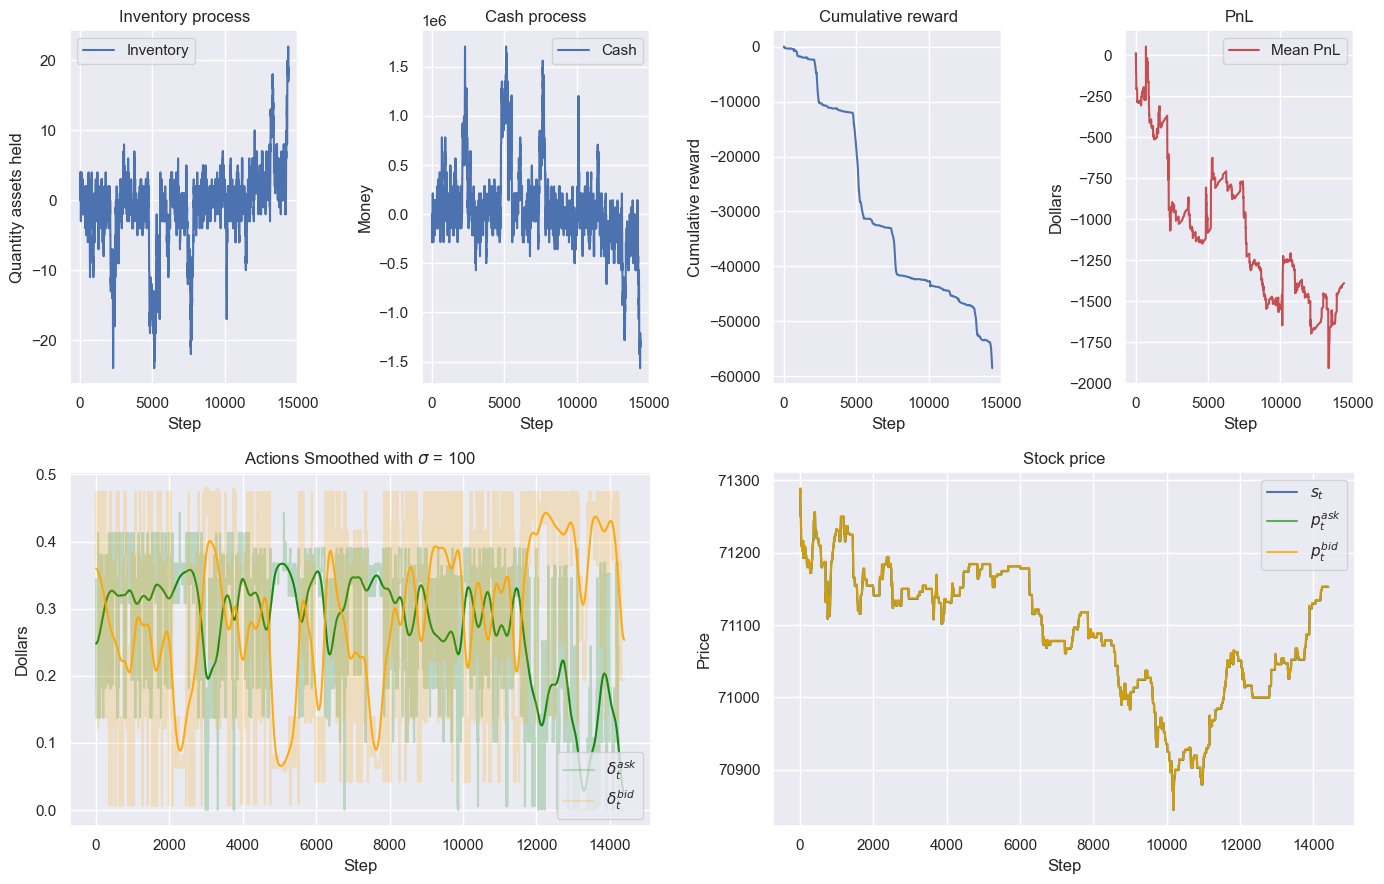

In [46]:
df1 = pd.read_pickle('lob-BTCUSDT-20240401.pkl')
BTest1_env = (trading_test(df=df1, num_trajectories=1))

ppo_agent = SbAgent(model)

observations, actions, rewards = generate_trajectory(BTest1_env, ppo_agent)

# Squeeze for the dimenson
rewards = np.squeeze(rewards, axis=1)

# Disregard the end value of observation (starting env)
observations = observations[:,:,:-1]

plot_agent_BT(observations, actions, rewards, True)

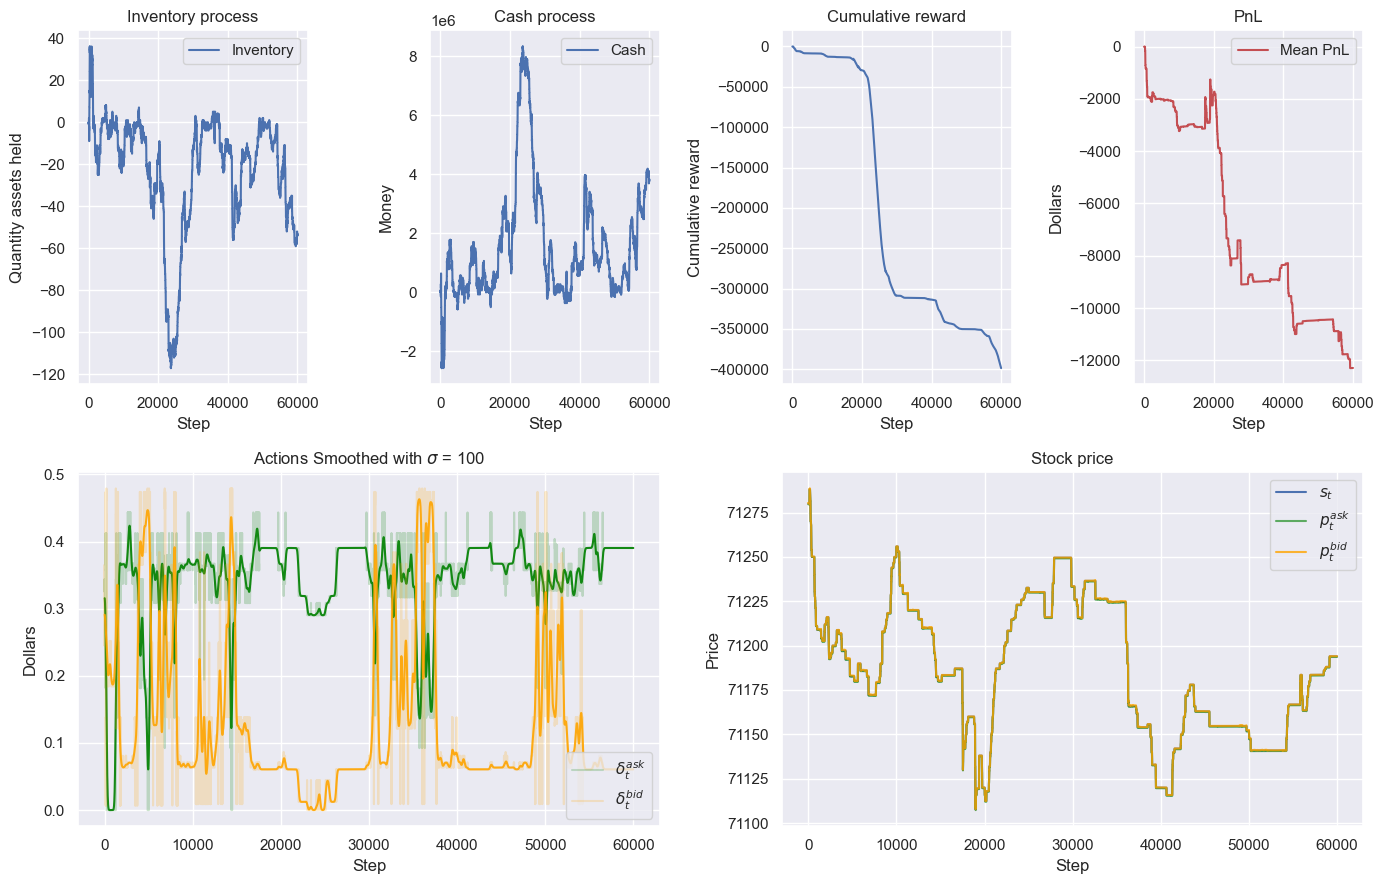

In [47]:
df2 = pd.read_pickle('lob-2-BTCUSDT-20240401.pkl')
BTest2_env = (trading_test(df=df2, num_trajectories=1))

ppo_agent = SbAgent(model)

observations, actions, rewards = generate_trajectory(BTest2_env, ppo_agent)

# Squeeze for the dimenson
rewards = np.squeeze(rewards, axis=1)

# Disregard the end value of observation (starting env)
observations = observations[:,:,:-1]

plot_agent_BT(observations, actions, rewards, True)

endmoney = observations[:, 1, :] * observations[:, 3, :] + observations[:, 0, :]
mean_wealth = endmoney.mean(axis=0)